In [30]:
from PIL import Image
from pathlib import Path

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from imutils import paths

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import Augmentor
import os
import datetime
import random
import pickle

In [2]:
pd.set_option('display.max_rows', None)

# Using Agnes Martin Catalog Data with Style, Motif, and Subject labels with images to train a CNN

**Process**
1. create a dataframe with the images and labels
2. split the dataset into train and test -> make sure the class distributions are the same for both
3. Build, train, test a baseline CNN model to predict the class of each image
4. Save the predictions (probability of each class) to be used as features in clustering model

## Step 1: create our feature matrix with our images and labels

In [3]:
# set path to data
data_path = '../src/Data/CSV_Files/'

# read csv file and print out first few rows
df = pd.read_csv(data_path+'catalog_data.csv')
df['id'] = df['id'].apply(lambda x: format(x, '.3f'))
df.head()

,id,link,title,no_pieces,circa,year_made,"medium (alpha, )",support,height (cm),width (cm),...,no_ex,no_exspaces,no_semsoloex,no_pub,red,green,blue,hue,saturation,light
0,1947.003,https://www.artifexpress.com/catalogues/agnes-...,Self Portrait,1,1,1947,encaustic,canvas,66.0,49.5,...,2,2,1,0,96,83,58,39,0.25,0.30
1,1947.006,https://www.artifexpress.com/catalogues/agnes-...,Portrait of Daphne Vaughn,1,1,1947,encaustic,canvas,50.8,40.6,...,2,4,0,4,122,65,36,20,0.54,0.31
2,1947.001,https://www.artifexpress.com/catalogues/agnes-...,Nude,1,0,1947,oil,canvas,50.8,40.6,...,3,6,0,4,125,122,73,57,0.26,0.39
3,1948.001,https://www.artifexpress.com/catalogues/agnes-...,Untitled,1,1,1948,encaustic,canvas,45.7,35.6,...,2,4,0,2,87,65,64,3,0.15,0.30
4,1949.001,https://www.artifexpress.com/catalogues/agnes-...,Untitled,1,1,1949,oil,masonite,25.6,53.3,...,2,4,0,6,91,48,38,11,0.41,0.25


In [4]:
# drop all columns except for id and subject
image_classes = df[['id', 'subject']]
image_classes.head()

,id,subject
0,1947.003,portrait
1,1947.006,portrait
2,1947.001,portrait
3,1948.001,still life
4,1949.001,abstract


In [15]:
image_classes['subject'].value_counts()

bands         255
repetition    196
grid           76
rectangle      47
square         19
symmetry       14
shape          10
circle          4
abstract        4
portrait        3
figure          3
gestural        2
landscape       2
na              2
still life      1
Name: subject, dtype: int64

In [67]:
class_name = image_classes['subject'].unique().tolist()

aug = {}

for subject in class_name:
    num = image_classes['subject'][image_classes['subject'] == subject].value_counts().values[0]
    num = 1000 - num
    aug[subject] = num
    
aug

{'portrait': 997,
 'still life': 999,
 'abstract': 996,
 'landscape': 998,
 'figure': 997,
 'shape': 990,
 'gestural': 998,
 'rectangle': 953,
 'square': 981,
 'symmetry': 986,
 'na': 998,
 'repetition': 804,
 'grid': 924,
 'circle': 996,
 'bands': 745}

# move images into folders for each class label (Subject)

In [64]:
for subject in class_name:
    temp = image_classes[image_classes["subject"] == subject]
    ids = temp['id'].values.tolist()
    subject = subject.replace(" ", "_")
    
    for a_id in ids:
        image_name = a_id + ".png"
        try:
            Path(f"./Data/Images/{image_name}").rename(f"./Data/Images/Subject/{subject}/{image_name}")
        except:
            pass

# load images, resize, created number of augmented images so we have balanced classes and more images to train on 

In [74]:
p = Augmentor.Pipeline('./Data/images/Subject/bands/')

Initialised with 252 image(s) found.
Output directory set to ./Data/images/Subject/bands/output.

In [75]:
# Defining augmentation parameters and generating 5 samples 
p.flip_left_right(0.5) 
p.black_and_white(0.15) 
p.rotate(0.6, 15, 15) 
p.skew(0.6, 0.5) 
p.zoom(probability = 0.3, min_factor = 1.4, max_factor = 2.0)
p.sample(1000)

Processing <PIL.Image.Image image mode=1 size=982x982 at 0x1B76FA597C8>: 100%|█| 1000/1000 [02:35<00:00,  6.43 Samples/


In [79]:
output_path = "./Data/Images/Subject/bands/output/"
subject = "bands"
f_names = os.listdir(output_path)
for i in range(len(f_names)):
    Path(output_path + f_names[i]).replace(f"{output_path}{subject}_{i+1}.png")

In [80]:
for subject in class_name:
    subject = subject.replace(" ", "_")
    path = f'./Data/images/Subject/{subject}/'
    p = Augmentor.Pipeline(path)
    
    # Defining augmentation parameters and generating 5 samples 
    p.flip_left_right(0.5) 
    p.black_and_white(0.15) b
    p.rotate(0.6, 15, 15) 
    p.skew(0.6, 0.5) 
    p.zoom(probability = 0.3, min_factor = 1.4, max_factor = 2.0)
    p.sample(1000)
    
    output_path = f"./Data/Images/Subject/{subject}/output/"
    f_names = os.listdir(output_path)
    for i in range(len(f_names)):
        Path(output_path + f_names[i]).replace(f"{output_path}{subject}_{i+1}.png")

Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to ./Data/images/Subject/portrait/output.

Processing <PIL.Image.Image image mode=RGBA size=790x1024 at 0x1B76F86B448>: 100%|█| 1000/1000 [03:23<00:00,  4.90 Samp
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 1 image(s) found.
Output directory set to ./Data/images/Subject/still_life/output.

Processing <PIL.Image.Image image mode=1 size=834x1024 at 0x1B76F572B08>: 100%|█| 1000/1000 [03:21<00:00,  4.95 Samples
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 4 image(s) found.
Output directory set to ./Data/images/Subject/abstract/output.

Processing <PIL.Image.Image image mode=RGBA size=1026x758 at 0x1B76BE12288>: 100%|█| 1000/1000 [02:51<00:00,  5.83 Samp
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 2 image(s) found.
Output directory set to ./Data/images/Subject/landscape/output.

Processing <PIL.Image.Image image mode=RGBA size=1026x870 at 0x1B76F598B08>: 100%|█| 1000/1000 [03:36<00:00,  4.62 Samp
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 3 image(s) found.
Output directory set to ./Data/images/Subject/figure/output.

Processing <PIL.Image.Image image mode=RGBA size=1028x710 at 0x1B70036D0C8>: 100%|█| 1000/1000 [03:19<00:00,  5.02 Samp
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 10 image(s) found.
Output directory set to ./Data/images/Subject/shape/output.

Processing <PIL.Image.Image image mode=RGBA size=872x606 at 0x1B76E79BE08>: 100%|█| 1000/1000 [02:36<00:00,  6.40 Sampl
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 1 image(s) found.
Output directory set to ./Data/images/Subject/gestural/output.

Processing <PIL.Image.Image image mode=RGBA size=870x542 at 0x1B7003F3B48>: 100%|█| 1000/1000 [02:03<00:00,  8.12 Sampl
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 46 image(s) found.
Output directory set to ./Data/images/Subject/rectangle/output.

Processing <PIL.Image.Image image mode=RGBA size=982x976 at 0x1B7005A7208>: 100%|█| 1000/1000 [03:54<00:00,  4.26 Sampl
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 19 image(s) found.
Output directory set to ./Data/images/Subject/square/output.

Processing <PIL.Image.Image image mode=RGBA size=970x962 at 0x1B76FF968C8>: 100%|█| 1000/1000 [04:23<00:00,  3.79 Sampl
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 14 image(s) found.
Output directory set to ./Data/images/Subject/symmetry/output.

Processing <PIL.Image.Image image mode=RGBA size=972x984 at 0x1B76FD8AA88>: 100%|█| 1000/1000 [03:51<00:00,  4.31 Sampl


Initialised with 0 image(s) found.
Output directory set to ./Data/images/Subject/na/output.

IndexError: There are no images in the pipeline. Add a directory using add_directory(), pointing it to a directory containing images.

In [81]:
class_name_left = [
    'repetition',
    'grid',
    'circle',
    'bands'
]

for subject in class_name_left:
    
    path = f'./Data/images/Subject/{subject}/'
    p = Augmentor.Pipeline(path)
    
    # Defining augmentation parameters and generating 5 samples 
    p.flip_left_right(0.5) 
    p.black_and_white(0.15) 
    p.rotate(0.6, 15, 15) 
    p.skew(0.6, 0.5) 
    p.zoom(probability = 0.3, min_factor = 1.4, max_factor = 2.0)
    p.sample(1000)
    
    output_path = f"./Data/Images/Subject/{subject}/output/"
    f_names = os.listdir(output_path)
    for i in range(len(f_names)):
        Path(output_path + f_names[i]).replace(f"{output_path}{subject}_{i+1}.png")

Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 193 image(s) found.
Output directory set to ./Data/images/Subject/repetition/output.

Processing <PIL.Image.Image image mode=1 size=790x798 at 0x1B77006C108>: 100%|█| 1000/1000 [02:47<00:00,  5.98 Samples/
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 74 image(s) found.
Output directory set to ./Data/images/Subject/grid/output.

Processing <PIL.Image.Image image mode=RGBA size=990x994 at 0x1B76F8F0688>: 100%|█| 1000/1000 [03:30<00:00,  4.75 Sampl
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 4 image(s) found.
Output directory set to ./Data/images/Subject/circle/output.

Processing <PIL.Image.Image image mode=RGBA size=978x986 at 0x1B700253A88>: 100%|█| 1000/1000 [03:48<00:00,  4.37 Sampl
Executing Pipeline:   0%|                                                               | 0/1000 [00:00<?, ? Samples/s]

Initialised with 252 image(s) found.
Output directory set to ./Data/images/Subject/bands/output.

Processing <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=982x984 at 0x1B76E9AD3C8>: 100%|█| 1000/1000 [03:30<00


# remove all white and all black images from the training_images

In [28]:
folders = os.listdir('./Data/train_images/')
folders.remove('test')
folders

['abstract',
 'bands',
 'circle',
 'figure',
 'gestural',
 'grid',
 'landscape',
 'portrait',
 'rectangle',
 'repetition',
 'shape',
 'square',
 'still_life',
 'symmetry']

In [29]:
for folder in folders:
    path = f"./Data/train_images/{folder}/"

    for filename in os.listdir(path):
        if filename.endswith('.png'):
            img = Image.open(path + filename)
            img = img.convert('1')
            clrs = img.getcolors()
            try:
                if len(clrs) == 1:
                    os.remove(path + filename)
            except:
                print(f"file: {filename}, has no colors/is none type")

# create CNN model

In [31]:
def build_model(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # if we are using channels first update input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)
        chanDim = 1

    # CONV -> RELU -> Pool layer set
    model.add(Conv2D(32, (3, 3), padding="same",
                     input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # (CONV -> RELU) * 2 -> Pool layer set
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # (CONV -> RELU) * 3 -> Pool
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first and only Fully Connected -> RELU layer
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the model
    return model

# initialize the data and labels

In [32]:
# initialize the data and labels
data = []
labels = []

# get image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('./Data/train_images/')))
random.seed(42)
random.shuffle(imagePaths)

In [34]:
# loop over input images
for imagePath in imagePaths:
    # load the image, resize to 64 x 64 pixels, store in data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))
    data.append(image)
    
    # extract class labels from the image path, update labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [42]:
# check to make sure labels are just the subject
labels[0]

'./Data/train_images/still_life'

In [46]:
# strip file path and return just subject label
labels = [label_split.split('/')[-1] for label_split in labels]

In [49]:
# scale raw pixels between [0, 1]
data = np.array(data, dtype="float") / 255.0

# make labels list and numpy array
labels = np.array(labels)

In [50]:
# split data and labels into train/test set, 80/20
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

In [55]:
# convert labels to vectors
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

In [59]:
# construct image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        fill_mode="nearest")

In [60]:
# initialize the smallVGGNet CNN
model = build_model(width=64, height=64, depth=3, classes=len(lb.classes_))

In [61]:
# initialize learning rate, epochs, and batch size
LR = 0.01
EPOCHS = 75
BS = 32

# initialize the model optimizer
opt = SGD(lr=LR, decay=LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [62]:
# train the model
history = model.fit(x=aug.flow(X_train, y_train, batch_size=BS),
                   validation_data=(X_test, y_test),
                   steps_per_epoch=len(X_train) // BS,
                   epochs=EPOCHS)

Epoch 1/75
354/354 [==============================] - 249s 704ms/step - loss: 2.2709 - accuracy: 0.3840 - val_loss: 4.7981 - val_accuracy: 0.1319
Epoch 2/75
354/354 [==============================] - 260s 735ms/step - loss: 1.5029 - accuracy: 0.5364 - val_loss: 3.0469 - val_accuracy: 0.3958
Epoch 3/75
354/354 [==============================] - 289s 816ms/step - loss: 1.2869 - accuracy: 0.5838 - val_loss: 1.4255 - val_accuracy: 0.5672
Epoch 4/75
354/354 [==============================] - 290s 820ms/step - loss: 1.1209 - accuracy: 0.6200 - val_loss: 2.0007 - val_accuracy: 0.4660
Epoch 5/75
354/354 [==============================] - 290s 819ms/step - loss: 1.0067 - accuracy: 0.6516 - val_loss: 2.6267 - val_accuracy: 0.3552
Epoch 6/75
354/354 [==============================] - 287s 810ms/step - loss: 0.9393 - accuracy: 0.6693 - val_loss: 1.6171 - val_accuracy: 0.4780
Epoch 7/75
354/354 [==============================] - 289s 818ms/step - loss: 0.8761 - accuracy: 0.6822 - val_loss: 1.7322 -

# evaluate the model and printout the classification report

In [63]:
pred = model.predict(x=X_test, batch_size=BS)
print(classification_report(y_test.argmax(axis=1), pred.argmax(axis=1), target_names=lb.classes_))

              precision    recall  f1-score   support

    abstract       0.98      0.68      0.80       191
       bands       0.85      0.13      0.22       180
      circle       1.00      0.28      0.43       217
      figure       0.80      0.09      0.17       171
    gestural       0.00      0.00      0.00       201
        grid       0.12      0.82      0.21       197
   landscape       0.97      0.74      0.84       208
    portrait       0.95      0.83      0.89       201
   rectangle       0.62      0.15      0.25       164
  repetition       0.17      0.18      0.18       167
       shape       1.00      0.39      0.56       204
      square       0.36      0.55      0.43       168
  still_life       0.99      0.98      0.98       194
    symmetry       0.44      0.30      0.36       180
        test       0.36      0.10      0.16       192

    accuracy                           0.42      2835
   macro avg       0.64      0.41      0.43      2835
weighted avg       0.65   

C:\Users\Andrew\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# plot the training loss and accuracy

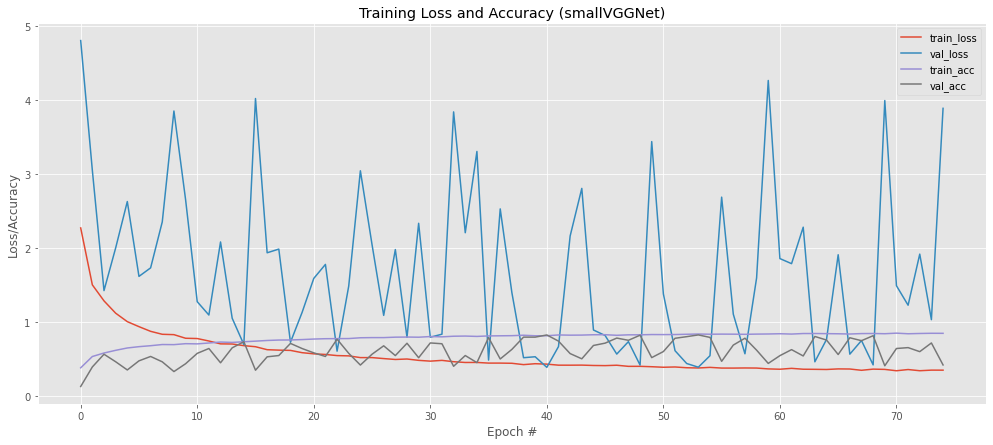

In [69]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(17,7))
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy (smallVGGNet)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# save the plot
plt.savefig("./output/first_pass_CNN.png")

# show the plot
plt.show();

# save the model and label binarizer

In [70]:
model.save("./output/first_pass_cnn.model", save_format="h5")
f = open("./output/first_pass_labels.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()